In [93]:
# a) Your Python code should create three predictors (Distance, Obstacle_Type, Angle_Approach) and one output variable (Time_Collision)

import os
import typing as t
from collections import namedtuple

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

import utils

glass_df = pd.read_csv(os.path.join("data", "Group2_1.csv"))

concrete_df = pd.read_csv(os.path.join("data", "Group2_2.csv"))

# the only usecase for zip lol
for df, obs_type in zip([glass_df, concrete_df], ["Glass", "Concrete"]):
    # df.set_index("Time", drop=True, inplace=True)
    # df.reindex().sort_index(ascending=False, inplace=True)
    df["Obstacle_type"] = obs_type
    df["Angle_Approach"] = (10 if obs_type == "Concrete" else 0) + np.random.uniform(
        -5, 5, df.shape[0]
    )
    df["Time_Collision"] = df["Value"] / 24


concrete_df

,Time,Value,Obstacle_type,Angle_Approach,Time_Collision
0,16:49:49,214.17,Concrete,5.764345,8.923750
1,16:49:50,214.17,Concrete,10.864673,8.923750
2,16:49:50,214.17,Concrete,12.322638,8.923750
3,16:49:50,214.17,Concrete,10.859481,8.923750
4,16:49:50,470.47,Concrete,8.434654,19.602917
...,...,...,...,...,...
159,16:50:09,5.51,Concrete,5.491984,0.229583
160,16:50:09,5.91,Concrete,7.979077,0.246250
161,16:50:09,5.91,Concrete,5.770560,0.246250
162,16:50:09,5.91,Concrete,10.825622,0.246250


In [94]:
# b) Your team can trim a few seconds of last rows of data where the same distance “Value” column in the datasets is exactly repeated.


def strip_similar_rows(
    df: pd.DataFrame,
    columns: str | list[str],
    side: t.Literal["start", "end", "both"] = "end",
    thresh=0.1,
) -> None:
    """
    THIS MUTATES THE DF

    strips the rows that are similar to the last row (acc to `tresh`),
    but it leaves the last row

    expects the dataframe to have an integer index


    args:
        - df (DataFrame): the dataframe to operate on
        - columns (str | list[str]): column(s) of the values to compare
        - side ("start", "end", "both"): where to strip rows, default "end"
        - tresh (float): +/- val to consider \n
    returns:
        - None

    """
    Row = namedtuple("Row", ["index", "series"])

    # WTF WAS THIS
    last = df["Value"].iloc[-1]
    if side == "both":
        side = "end"
        strip_similar_rows(df, columns, "start", thresh)
    # iterrows() is a bad idea but whatever
    rows_since_dupe = 0
    to_drop: list[Row] = []
    for i, row in (df[::-1] if side == "end" else df).iterrows():
        if rows_since_dupe > 1:
            break
        if not (last - thresh <= row[columns] <= last + thresh):
            rows_since_dupe += 1
            continue
        to_drop.append(Row(i, row))
    df.drop(index=[i.index for i in to_drop], inplace=True)
    df.loc[len(df)] = to_drop[-1].series


strip_similar_rows(glass_df, "Value", "end", 0.2)
strip_similar_rows(concrete_df, "Value", "end", 0.4)
# glass_df

# [i for i in concrete_df["Time"] if not isinstance(i,)]

In [95]:
# C) After trimming, deal with seconds that do not have exactly 10 records in them as directed below:
# - You can choose to impute the median/mean or any other statistic (of your choice) of distance measurements in that particular missing time step.
# - Where your imputed records go is also optional: in the beginning of that particular second, middle, etc.
# - Whether you impute all missing records in each second next to each other or randomly spread among all other records in that second is also your choice.
for df in (concrete_df, glass_df):
    for _time, _count in df.groupby("Time").count()["Value"].items():
        if _count >= 10:
            continue
        row_to_opp = df.loc[(df["Time"] == _time)]  # row to operate on
        cols_to_avg = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        new_row = row_to_opp[cols_to_avg].mean()
        for col in (c for c in df.columns if c not in cols_to_avg):
            new_row[col] = row_to_opp[col].iloc[0]
        for _ in range(10 - _count):
            df.loc[len(df)] = new_row
    df.sort_values(["Time", "Value"], ascending=[True, False], inplace=True)
    df.reset_index(drop=True, inplace=True)
# glass_df

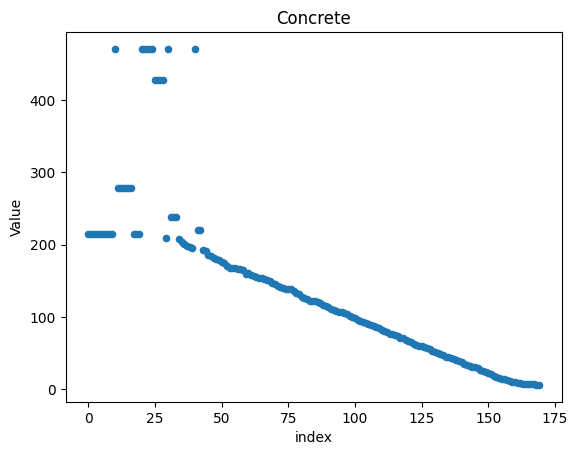

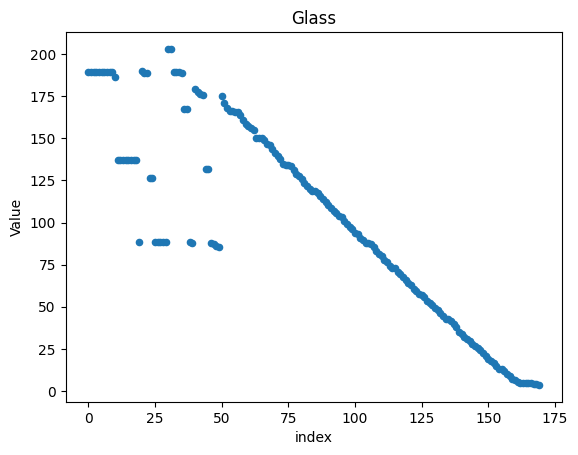

In [96]:
# D) Report and handle missing and outlier values

for df in concrete_df, glass_df:
    df.reset_index().plot(
        y="Value", x="index", kind="scatter", title=df["Obstacle_type"].iloc[0]
    )

In [97]:
# there are outliers in concrete_df where value > ~250

# there are outliers in glass_df where value < 150 and index < ~60

# if we wanted, we could clean out closer cut outliers but ehhhhhh

for df in (concrete_df, glass_df):
    if df["Obstacle_type"].iloc[0] == "Concrete":
        df.drop(df[(df["Value"] > 220)].index, inplace=True)
        continue
    df.drop(
        df[((df["Value"] > 200) | (df["Value"] < 150)) & (df.index < 60)].index,
        inplace=True,
    )

<Axes: title={'center': 'Value vs index'}, xlabel='index', ylabel='Value_glass'>

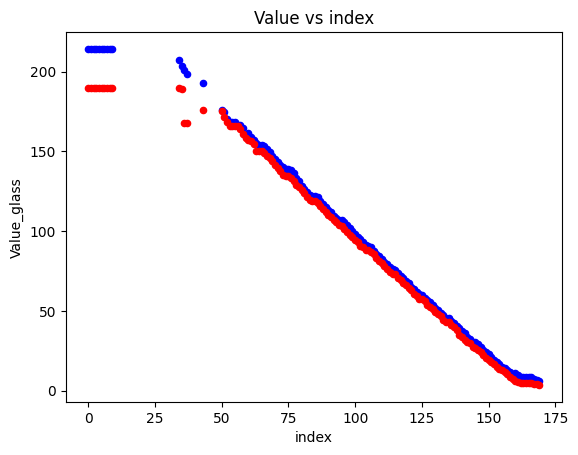

In [98]:
# Use two plots of choice that make the most sense to present the nature of the data to a reader and to determine how both scenarios were similar and/or different.

merged_df = concrete_df.merge(
    glass_df,
    how="inner",
    left_index=True,
    right_index=True,
    suffixes=("_concrete", "_glass"),
).reset_index()
ax = merged_df.plot(
    x="index",
    y="Value_concrete",
    kind="scatter",
    color="b",
    title="Value vs index",
    ylabel="Value",
)
merged_df.plot(x="index", y="Value_glass", kind="scatter", color="r", ax=ax)

Text(0.5, 1.0, 'corralation and effect of weather conditions upon each other')

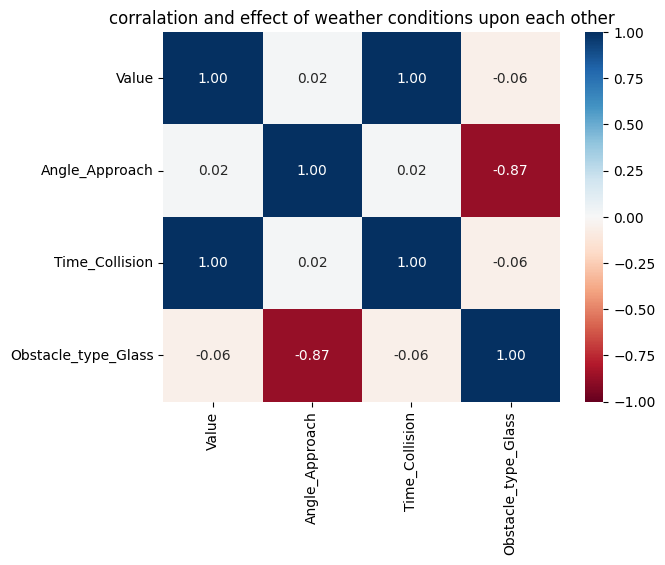

In [99]:
concat_df = pd.get_dummies(
    pd.concat([concrete_df, glass_df])
    .drop(columns=["Time"])
    .apply(lambda x: x.astype("category") if x.name == "Obstacle_type" else x),
    prefix_sep="_",
    dummy_na=False,
    drop_first=True,
    dtype=int,
    columns=["Obstacle_type"],
)
corr = concat_df.corr()

ax_heatmap = sns.heatmap(
    corr,
    xticklabels=corr.columns.to_list(),  # mypy complains without `to_list()`
    yticklabels=corr.columns.to_list(),
    cmap="RdBu",
    vmin=-1,
    vmax=1,  # i don't think u need these
    annot=True,
    fmt=".2f",  # by default
    center=0,
)

ax_heatmap.set_title("corralation and effect of weather conditions upon each other")

In [100]:
# f) Combine the two datasets for both scenarios to get around 340 to 400 rows (34 to 40 seconds).
concat_df

,Value,Angle_Approach,Time_Collision,Obstacle_type_Glass
0,214.170,5.764345,8.923750,0
1,214.170,5.764345,8.923750,0
2,214.170,5.764345,8.923750,0
3,214.170,5.764345,8.923750,0
4,214.170,5.764345,8.923750,0
...,...,...,...,...
165,4.646,-1.411736,0.193583,1
166,4.646,-1.411736,0.193583,1
167,4.330,-2.314967,0.180417,1
168,3.940,-0.542386,0.164167,1


In [101]:
# g) Shuffle the data (in any way you can/want) to avoid data overfitting when using k-NN and Naive Bayes
concat_df = concat_df.sample(frac=1)
concat_df

,Value,Angle_Approach,Time_Collision,Obstacle_type_Glass
81,123.620000,-4.117911,5.150833,1
73,135.040000,-4.901517,5.626667,1
84,118.698750,0.081429,4.945781,1
145,30.665556,10.190042,1.277731,0
40,179.130000,4.680423,7.463750,1
...,...,...,...,...
90,110.240000,-3.975969,4.593333,1
95,103.281111,-1.231878,4.303380,1
161,9.450000,13.230690,0.393750,0
138,40.550000,6.536101,1.689583,0


In [102]:
# 3) Model Training (15 pts.): Your team needs to split the data into 60% training and 40% validation.
# You should:
# a) Train and validate a k-Nearest Neighbors (k-NN) model.


normalized_df = utils.normalize_df(
    concat_df, *(c for c in concat_df.columns if c != "Obstacle_type_Glass")
)


df_list: list[pd.DataFrame | pd.Series] = train_test_split(
    normalized_df, test_size=0.4, random_state=1
)

train_x, valid_x = df_list

In [103]:
knn = NearestNeighbors(n_neighbors=3)
knn.fit(train_x)
distances, indices = knn.kneighbors(normalized_df)
normalized_df.iloc[indices[0], :]

,Obstacle_type_Glass,Value,Angle_Approach,Time_Collision
97,0,0.018569,1.274004,0.018569
89,1,0.147801,-0.125810,0.147801
55,0,0.985619,-1.103442,0.985619


In [104]:
outcome = "Obstacle_type_Glass"
predictors = [c for c in normalized_df.columns if c != outcome]
output = pd.DataFrame(
    [
        {
            "k": k,
            "accuracy": accuracy_score(
                valid_x[outcome],
                KNeighborsClassifier(n_neighbors=k)
                .fit(train_x[predictors], train_x[outcome])
                .predict(valid_x[predictors]),
            ),
        }
        for k in range(1, 15)
    ]
)
output

,k,accuracy
0,1,0.275556
1,2,0.404444
2,3,0.306667
3,4,0.382222
4,5,0.342222
5,6,0.404444
6,7,0.400000
7,8,0.404444
8,9,0.408889
9,10,0.404444


In [105]:
# To work with Naïve Bayes, label “Time_Collision” as Low, Medium, High based on your
# team`s choice of threshold. You can choose to follow this or any other three thresholds of your choice: IF(Time_Collision<2, "Close", IF(Time_Collision<6, "Mid", IF(Time_Collision >=6,
# "Far"))). Train and validate a Multinomial Naive Bayes (NB) model. Hint: Multinomial NB
# does not handle continuous values such a Distance or Angle_Approach values, it works with
# discrete values only


concat_df_copy = concat_df.copy(deep=True)
for column in concat_df_copy.columns:
    if (
        not pd.api.types.is_numeric_dtype(concat_df_copy[column])
        or column == "Obstacle_type_Glass"
    ):
        continue
    desc = concat_df_copy.describe()
    concat_df_copy[column] = (
        concat_df_copy[column]
        .apply(
            lambda x: (
                "Low"
                if x < desc.loc["25%"][column]
                else "Medium" if x < desc.loc["75%"][column] else "High"
            )
        )
        .astype("category")
    )

x_train, x_valid, y_train, y_valid = train_test_split(
    pd.get_dummies(concat_df_copy, drop_first=True, dtype=int),
    concat_df["Obstacle_type_Glass"],
    test_size=0.40,
    random_state=1,
)


glass_nb = MultinomialNB(alpha=0.01)  # alpha is a smoothing hyperparameter
glass_nb.fit(x_train, y_train)

pred_train = glass_nb.predict_proba(x_train)
pred_valid = glass_nb.predict_proba(x_valid)

y_valid_pred = glass_nb.predict(x_valid)

y_valid_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1])